# Clustering

In [5]:
using Clustering # Algorithms (K-means, DBSCAN, Hierarchical
                 # clustering), validation (silhouettes, V-Measure)
using DataFrames
using Statistics
using JSON # JSON parsing and printing
using CSV
using Distances 

In order to try the different algorithms I will be using a 2-dimensional data.

In [6]:
x1 = []
x2 = []
open("data/2d-clustering.txt") do file
    for line in eachline(file)
        values = split(line)
        push!(x1, parse(Float64, values[1]))
        push!(x2, parse(Float64, values[2]))
    end
end

In [7]:
dataset = DataFrame(:x1=>x1, :x2=>x2);

In [8]:
describe(dataset)

2×8 DataFrame. Omitted printing of 2 columns
│ Row │ variable │ mean     │ min     │ median   │ max      │ nunique │
│     │ Symbol   │ Float64  │ Float64 │ Float64  │ Float64  │ Int64   │
├─────┼──────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 1   │ x1       │ 514938.0 │ 19835.0 │ 505338.0 │ 961951.0 │ 4987    │
│ 2   │ x2       │ 494709.0 │ 51121.0 │ 526260.0 │ 970756.0 │ 4973    │

Before applying any algorithm, we standarize and visualize the data. Since the data is 2-dimensional, there is no need to apply any dimensionality reduction.

In [9]:
using StatsPlots

In [10]:
means = [mean(dataset.x1), mean(dataset.x2)]
stds = [std(dataset.x1), std(dataset.x2)];

dataset.stdX1 = (dataset.x1 .- means[1]) ./ stds[1]
dataset.stdX2 = (dataset.x2 .- means[2]) ./ stds[2];

In [11]:
describe(dataset)

4×8 DataFrame. Omitted printing of 2 columns
│ Row │ variable │ mean         │ min      │ median     │ max      │ nunique │
│     │ Symbol   │ Float64      │ Float64  │ Float64    │ Float64  │ Union…  │
├─────┼──────────┼──────────────┼──────────┼────────────┼──────────┼─────────┤
│ 1   │ x1       │ 514938.0     │ 19835.0  │ 505338.0   │ 961951.0 │ 4987    │
│ 2   │ x2       │ 494709.0     │ 51121.0  │ 526260.0   │ 970756.0 │ 4973    │
│ 3   │ stdX1    │ -4.54747e-17 │ -2.02524 │ -0.0392654 │ 1.82853  │         │
│ 4   │ stdX2    │ 0.0          │ -1.88088 │ 0.133778   │ 2.01851  │         │

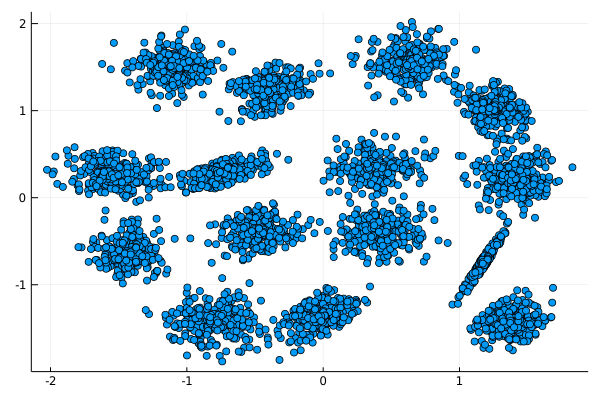

In [28]:
@df dataset scatter(:stdX1, :stdX2, label=nothing)

It's reasonably easy to identify **15** clusters among the data. So, when applying the different clustering algorithms, we know that we should select K=15 in those algorithms that need the number of clusters as input.

In [13]:
K = 15

15

## 1. K-means clustering

In [14]:
?Clustering.kmeansdbscan()

```
kmeans(X, k, [...]) -> KmeansResult
```

K-means clustering of the $d×n$ data matrix `X` (each column of `X` is a $d$-dimensional data point) into `k` clusters.

# Arguments

  * `init` (defaults to `:kmpp`): how cluster seeds should be initialized, could be one of the following:

      * a `Symbol`, the name of a seeding algorithm (see [Seeding](@ref) for a list of supported methods);
      * an instance of [`SeedingAlgorithm`](@ref);
      * an integer vector of length $k$ that provides the indices of points to use as initial seeds.
  * `weights`: $n$-element vector of point weights (the cluster centers are the weighted means of cluster members)
  * `maxiter`, `tol`, `display`: see [common options](@ref common_options)


In [15]:
X = Matrix(dataset[!, [:stdX1, :stdX2]])'
@show typeof(X)
@show size(X)

typeof(X) = LinearAlgebra.Adjoint{Float64,Array{Float64,2}}
size(X) = (2, 5000)


(2, 5000)

In [16]:
#C = kmeans(X, 15) # Error when executing

## 2. K-medoids clustering

In [17]:
X = Matrix(dataset[!, [:stdX1, :stdX2]])';

In [18]:
D = pairwise(Distances.Euclidean(), X, X, dims=2);
size(D)

(5000, 5000)

In [29]:
C = kmedoids(D, K)

KmedoidsResult{Float64}([2512, 944, 67, 545, 4138, 2927, 2159, 647, 4866, 1411, 4404, 1596, 2784, 3454, 3892], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [0.26449175189565316, 0.26154907278376516, 0.02913373549036655, 0.11309957381149541, 0.19298804386206123, 0.09628168593128819, 0.14932809439423222, 0.002687134230346665, 0.27093875666167827, 0.0029164126206264207  …  0.07051033232065655, 0.3207350274631512, 0.2255853095015111, 0.03501766522901425, 0.3002140908348417, 0.04198536562372087, 0.07821460756010198, 0.09153795505173665, 0.3002757220992322, 0.08882870318379692], [335, 318, 297, 315, 351, 340, 334, 314, 353, 327, 350, 328, 341, 346, 351], 704.1226520970221, 3, true)

In [31]:
insertcols!(dataset, 5, :medoidsCluster=>C.assignments)
describe(dataset)

6×8 DataFrame. Omitted printing of 3 columns
│ Row │ variable       │ mean         │ min      │ median     │ max      │
│     │ Symbol         │ Float64      │ Real     │ Float64    │ Real     │
├─────┼────────────────┼──────────────┼──────────┼────────────┼──────────┤
│ 1   │ x1             │ 514938.0     │ 19835.0  │ 505338.0   │ 961951.0 │
│ 2   │ x2             │ 494709.0     │ 51121.0  │ 526260.0   │ 970756.0 │
│ 3   │ stdX1          │ -4.54747e-17 │ -2.02524 │ -0.0392654 │ 1.82853  │
│ 4   │ stdX2          │ 0.0          │ -1.88088 │ 0.133778   │ 2.01851  │
│ 5   │ medoidsCluster │ 8.1084       │ 1        │ 8.0        │ 15       │
│ 6   │ hClusters      │ 4.6556       │ 1        │ 3.0        │ 15       │

Once we have the assigment of every point, we can represent the different clusters.

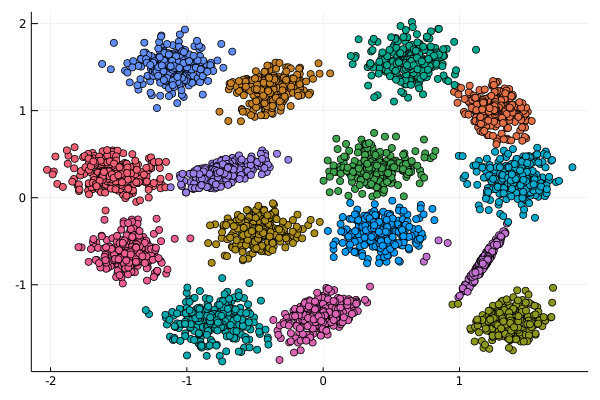

In [33]:
@df dataset scatter(:stdX1, :stdX2, markercolor=:medoidsCluster, label=nothing)

## 3. Hierarchial Clustering

In [22]:
C = hclust(D)
L = cutree(C; k=K);

In [23]:
insertcols!(dataset, 6, :hClusters=>L);

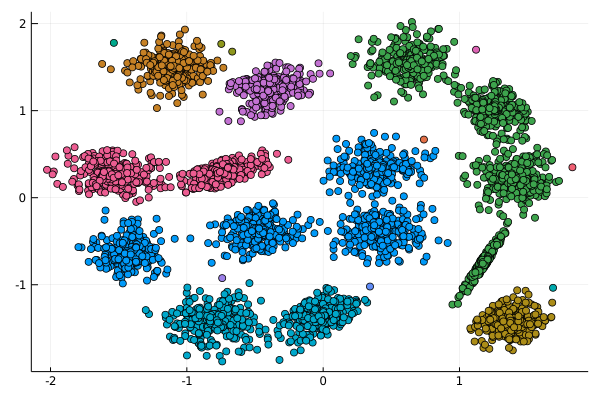

In [34]:
@df dataset scatter(:stdX1, :stdX2, markercolor=:hClusters, label=nothing)

## 4. DBSCAN

In [25]:
?dbscan

search: dbscan DbscanResult DbscanCluster



```
dbscan(D::AbstractMatrix, eps::Real, minpts::Int) -> DbscanResult
```

Perform DBSCAN algorithm using the distance matrix `D`.

# Arguments

The following options control which points would be considered *density reachable*:

  * `eps::Real`: the radius of a point neighborhood
  * `minpts::Int`: the minimum number of neighboring points (including itself)  to qualify a point as a density point.

---

```
dbscan(points::AbstractMatrix, radius::Real,
       [leafsize], [min_neighbors], [min_cluster_size]) -> Vector{DbscanCluster}
```

Cluster `points` using the DBSCAN (density-based spatial clustering of applications with noise) algorithm.

# Arguments

  * `points`: the $d×n$ matrix of points. `points[:, j]` is a $d$-dimensional coordinates of $j$-th point
  * `radius::Real`: query radius

Optional keyword arguments to control the algorithm:

  * `leafsize::Int` (defaults to 20): the number of points binned in each leaf node in the `KDTree`
  * `min_neighbors::Int` (defaults to 1): the minimum number of a *core* point neighbors
  * `min_cluster_size::Int` (defaults to 1): the minimum number of points in a valid cluster

# Example

```julia
points = randn(3, 10000)
# DBSCAN clustering, clusters with less than 20 points will be discarded:
clusters = dbscan(points, 0.05, min_neighbors = 3, min_cluster_size = 20)
```


In [58]:
C = dbscan(D, 0.1, 7)

DbscanResult([1, 156, 301, 328, 617, 1249, 1574, 1724, 1900, 2572, 2913, 3951], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [283, 326, 313, 988, 309, 320, 328, 335, 329, 327, 678, 345])

In [59]:
insertcols!(dataset, :dbscanCluster=> C.assignments);


In [60]:
describe(dataset)

7×8 DataFrame. Omitted printing of 3 columns
│ Row │ variable       │ mean         │ min      │ median     │ max      │
│     │ Symbol         │ Float64      │ Real     │ Float64    │ Real     │
├─────┼────────────────┼──────────────┼──────────┼────────────┼──────────┤
│ 1   │ x1             │ 514938.0     │ 19835.0  │ 505338.0   │ 961951.0 │
│ 2   │ x2             │ 494709.0     │ 51121.0  │ 526260.0   │ 970756.0 │
│ 3   │ stdX1          │ -4.54747e-17 │ -2.02524 │ -0.0392654 │ 1.82853  │
│ 4   │ stdX2          │ 0.0          │ -1.88088 │ 0.133778   │ 2.01851  │
│ 5   │ medoidsCluster │ 8.1084       │ 1        │ 8.0        │ 15       │
│ 6   │ hClusters      │ 4.6556       │ 1        │ 3.0        │ 15       │
│ 7   │ dbscanCluster  │ 6.4192       │ 0        │ 6.0        │ 12       │

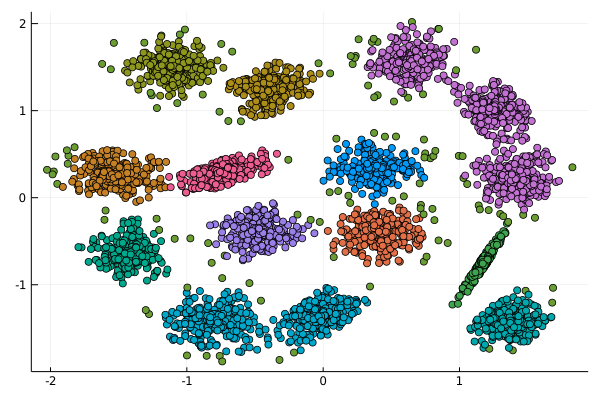

In [61]:
@df dataset scatter(:stdX1, :stdX2, markercolor=:dbscanCluster, label=nothing)